In [1]:
pip install CoolProp

In [2]:
import os
import CoolProp.CoolProp as CP  # Thermodynamic Tables
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [3]:
pressures = np.linspace(1, 1250, 50) #Thermodynamic Tables has maximum range of pressure from 1 to 1250 MPa
#Cleaning Pressure values
pressures = np.round(pressures)
pressures = np.unique(pressures)
temperatures = np.linspace(0.1, 800, 100)
columns = ['Pressure (MPa)', 'Temperature (°C)', 'Specific Volume (m³/kg)',
               'Enthalpy (kJ/kg)', 'Entropy (kJ/kg·K)', 'Internal Energy (kJ/kg)',
               'Viscosity (μPa·s)', 'Thermal Conductivity (mW/m·K)',
               'Density (kg/m³)', 'Prandtl Number (dimensionless)']
#Values to be Predicted
target_labels = [
    'Specific Volume (m³/kg)', 'Enthalpy (kJ/kg)', 'Entropy (kJ/kg·K)',
    'Internal Energy (kJ/kg)', 'Viscosity (μPa·s)', 'Thermal Conductivity (mW/m·K)',
    'Density (kg/m³)', 'Prandtl Number (dimensionless)'
]



selected_pressures = pressures[::5]  # Select every 5th value (50 / 10 = 5)
#Regressors used
regressors = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.1, random_state=3),
    "Polynomial Regression (Degree=2)": Pipeline([
        ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
        ('linear_regression', LinearRegression())
    ]),
    "Support Vector Regression": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=3),
    "Random Forest": RandomForestRegressor(random_state=3),
    "XGBoost": XGBRegressor(random_state=3),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Neural Network Regression": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=3)
}
results = {}

Creates the data used for predictions

In [4]:
def data_generation(pressures, temperatures):
    data = []
    for P in pressures:
        for T in temperatures:
            try:
                # Calculate properties for the given pressure and temperature
                v = 1 / CP.PropsSI('D', 'P', P * 1e6, 'T', T + 273.15, 'Water')  #(m³/kg)
                h = CP.PropsSI('H', 'P', P * 1e6, 'T', T + 273.15, 'Water') / 1000  # Enthalpy (kJ/kg)
                s = CP.PropsSI('S', 'P', P * 1e6, 'T', T + 273.15, 'Water') / 1000  # Entropy (kJ/kg·K)
                u = CP.PropsSI('U', 'P', P * 1e6, 'T', T + 273.15, 'Water') / 1000  # Internal energy (kJ/kg)
                eta = CP.PropsSI('VISCOSITY', 'P', P * 1e6, 'T', T + 273.15, 'Water') * 1e6  # Viscosity (μPa·s)
                lambd = CP.PropsSI('CONDUCTIVITY', 'P', P * 1e6, 'T', T + 273.15, 'Water') * 1e3  # Thermal conductivity (mW/m·K)
                rho = CP.PropsSI('D', 'P', P * 1e6, 'T', T + 273.15, 'Water')  # Density (kg/m³)
                Pr = eta * CP.PropsSI('C', 'P', P * 1e6, 'T', T + 273.15, 'Water') / lambd  # Prandtl number
                # Append data to the list
                data.append([P, T, v, h, s, u, eta, lambd, rho, Pr])
            except Exception as e:
                print(f"Error at P={P} MPa, T={T} °C: {e}")
                continue
    return data

Checks if data already exists if not Generate the data

In [5]:
# Define the output file path
output_file = 'steam_table_pressure_temperature.csv'
# Check if the file exists
if os.path.exists(output_file):
    # If the file exists, load it into a DataFrame
    df = pd.read_csv(output_file)
    print(f"Data loaded from existing file: {output_file}")
else:
    # Generate data
    data = data_generation(pressures, temperatures)
    df = pd.DataFrame(data, columns=columns)
    df = df.drop_duplicates(subset=['Pressure (MPa)', 'Temperature (°C)'])
    # Save the data to a CSV file
    df.to_csv(output_file, index=False)
    print(f"Data generated, deduplicated, and saved to file: {output_file}")

Data generated, deduplicated, and saved to file: steam_table_pressure_temperature.csv


Split the data into testing and training

In [6]:
# Define the features (X) and target variables (y)
X = df[['Pressure (MPa)', 'Temperature (°C)']].values  # Features: Pressure and Temperature
y = df.iloc[:, 2:].values  # Target variables: All other properties
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3, random_state=3, shuffle=True)


In [7]:
def plot_actual_viscosity_vs_temperature_fixed(Xts, yts, pressures_to_plot):
    plt.figure(figsize=(12, 8))
    for pressure in pressures_to_plot:
        # Filter the data for the specific pressure
        indices_at_pressure = np.isclose(Xts[:, 0], pressure, atol=0.01)  # Check pressure in the first column of Xts
        temperatures = Xts[indices_at_pressure, 1]  # Extract temperatures for the filtered rows
        actual_viscosity = yts[indices_at_pressure, 5]  # Extract actual viscosity for the filtered rows
        if len(temperatures) > 0:  # Ensure there are data points to plot
            # Sort data by temperature to ensure smooth lines
            sorted_indices = np.argsort(temperatures)
            temperatures_sorted = temperatures[sorted_indices]
            viscosity_sorted = actual_viscosity[sorted_indices]
            # Plot the sorted data
            plt.plot(temperatures_sorted, viscosity_sorted, label=f'{pressure:.2f} MPa', marker='o', alpha=0.7)
        else:
            print(f"No data found for Pressure = {pressure} MPa")
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Viscosity (μPa·s)')
    plt.title('Viscosity vs Temperature at Different Pressures (Actual Data)')
    plt.legend(title="Pressure (MPa)", loc='best')
    plt.grid(True)
    plt.show()

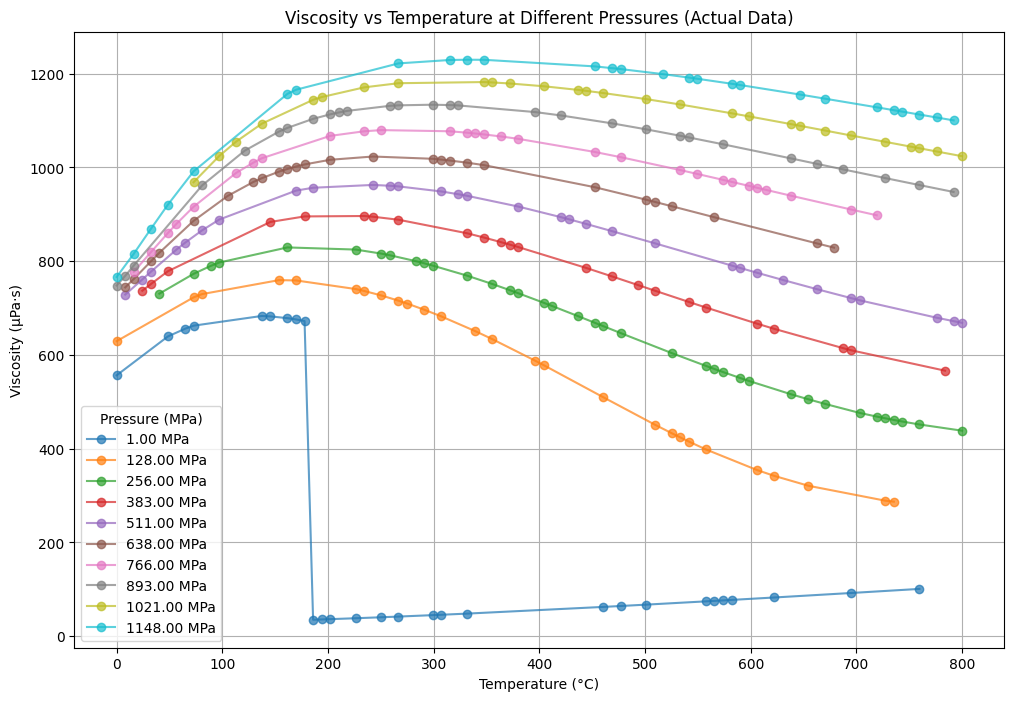

In [8]:
plot_actual_viscosity_vs_temperature_fixed(Xts, yts, selected_pressures)

In [9]:
# Initialize the best and worst results dictionary
best_worst_results = {label: {"best_regressor": None, "best_mse": float('inf'),
                              "worst_regressor": None, "worst_mse": float('-inf')}
                      for label in target_labels}

# Dictionary to store results for each regressor
results = {}

# Train each regressor and compute MSEs
for name, base_model in regressors.items():
    print(f"Training {name}...")
    model = MultiOutputRegressor(base_model)
    model.fit(Xtr, ytr)
    ypred = model.predict(Xts)

    # Calculate the MSE for each target variable
    mse = mean_squared_error(yts, ypred, multioutput='raw_values')
    avg_mse = np.mean(mse)  # Calculate average MSE across all targets
    results[name] = {
        "model": model,
        "ypred": ypred,
        "mse": mse,
        "avg_mse": avg_mse,
    }

    # Print MSE for each target variable
    print(f"\n{name} - Mean Squared Error for each target:")
    for label, error in zip(target_labels, mse):
        print(f"{label}: {error:.4e}")
        # Update the best regressor for the target
        if error < best_worst_results[label]["best_mse"]:
            best_worst_results[label]["best_regressor"] = name
            best_worst_results[label]["best_mse"] = error
        # Update the worst regressor for the target
        if error > best_worst_results[label]["worst_mse"]:
            best_worst_results[label]["worst_regressor"] = name
            best_worst_results[label]["worst_mse"] = error
    print(f"Average MSE for {name}: {avg_mse:.4e}")
    print("-" * 40)

# Compare average MSE across all models
print("\nComparison of Average MSE Across Regressors:")
for name, result in results.items():
    print(f"{name}: Average MSE = {result['avg_mse']:.4e}")

# Prepare data for the CSV file
output_data = []
header = ["Target Variable"] + list(results.keys())  # Header row: target variable + regressor names

# Populate the rows with MSE values for each target variable
for i, label in enumerate(target_labels):
    row = [label]  # First column is the target variable name
    for name in results.keys():
        row.append(f"{results[name]['mse'][i]:.4e}")  # Add MSE for the current regressor
    output_data.append(row)

# Add the row for average MSE
average_row = ["Average MSE"]
for name in results.keys():
    average_row.append(f"{results[name]['avg_mse']:.4e}")
output_data.append(average_row)

# Save to a CSV file
output_file = "regressor_mse_results.csv"
with open(output_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)  # Write the header row
    writer.writerows(output_data)  # Write all rows of data

print(f"\nResults saved to {output_file}")

Training Linear Regression...

Linear Regression - Mean Squared Error for each target:
Specific Volume (m³/kg): 1.2982e-03
Enthalpy (kJ/kg): 4.5582e+04
Entropy (kJ/kg·K): 2.8013e-01
Internal Energy (kJ/kg): 3.8522e+04
Viscosity (μPa·s): 1.1597e+05
Thermal Conductivity (mW/m·K): 1.6237e+04
Density (kg/m³): 1.2611e+04
Prandtl Number (dimensionless): 2.8571e+06
Average MSE for Linear Regression: 3.8575e+05
----------------------------------------
Training Lasso Regression...

Lasso Regression - Mean Squared Error for each target:
Specific Volume (m³/kg): 1.2949e-03
Enthalpy (kJ/kg): 4.5582e+04
Entropy (kJ/kg·K): 2.8011e-01
Internal Energy (kJ/kg): 3.8522e+04
Viscosity (μPa·s): 1.1597e+05
Thermal Conductivity (mW/m·K): 1.6237e+04
Density (kg/m³): 1.2611e+04
Prandtl Number (dimensionless): 2.8571e+06
Average MSE for Lasso Regression: 3.8575e+05
----------------------------------------
Training Polynomial Regression (Degree=2)...

Polynomial Regression (Degree=2) - Mean Squared Error for eac

In [10]:
def plot_all_targets_comparison_for_regressors(results, Xts, yts, pressure, target_labels):
    # Filter the test data for the specified pressure
    indices_at_pressure = np.isclose(Xts[:, 0], pressure, atol=0.01)
    temperatures = Xts[indices_at_pressure, 1]  # Extract temperatures for the filtered rows
    if len(temperatures) > 0:
        # Sort the data by temperature for smooth lines
        sorted_indices = np.argsort(temperatures)
        temperatures_sorted = temperatures[sorted_indices]
        num_targets = yts.shape[1]
        plt.figure(figsize=(16, 12))
        for i in range(num_targets):
            # Sort actual values by temperature
            actual_values = yts[indices_at_pressure, i]
            actual_values_sorted = actual_values[sorted_indices]
            # Plot actual data
            plt.subplot((num_targets + 1) // 2, 2, i + 1)
            plt.plot(temperatures_sorted, actual_values_sorted, color='black', label='Actual', linewidth=2)
            # Plot predicted values for each regressor
            for name, result in results.items():
                ypred = result["ypred"]
                predicted_values = ypred[indices_at_pressure, i]
                predicted_values_sorted = predicted_values[sorted_indices]
                plt.plot(temperatures_sorted, predicted_values_sorted, label=f"{name} (Predicted)", alpha=0.8)
            plt.title(target_labels[i])
            plt.xlabel('Temperature (°C)')
            plt.ylabel(target_labels[i])
            plt.grid(True)
            # Position the legend outside the plot area
            if i % 2 == 0:  # For left-side subplots
                plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small', frameon=False)
            else:  # For right-side subplots
                plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small', frameon=False)
        plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to accommodate legends
        plt.suptitle(f'Comparison of Predicted Values for All Targets at Pressure = {pressure} MPa', y=1.02, fontsize=16)
        plt.show()
    else:
        print(f"No test data found for Pressure = {pressure} MPa")

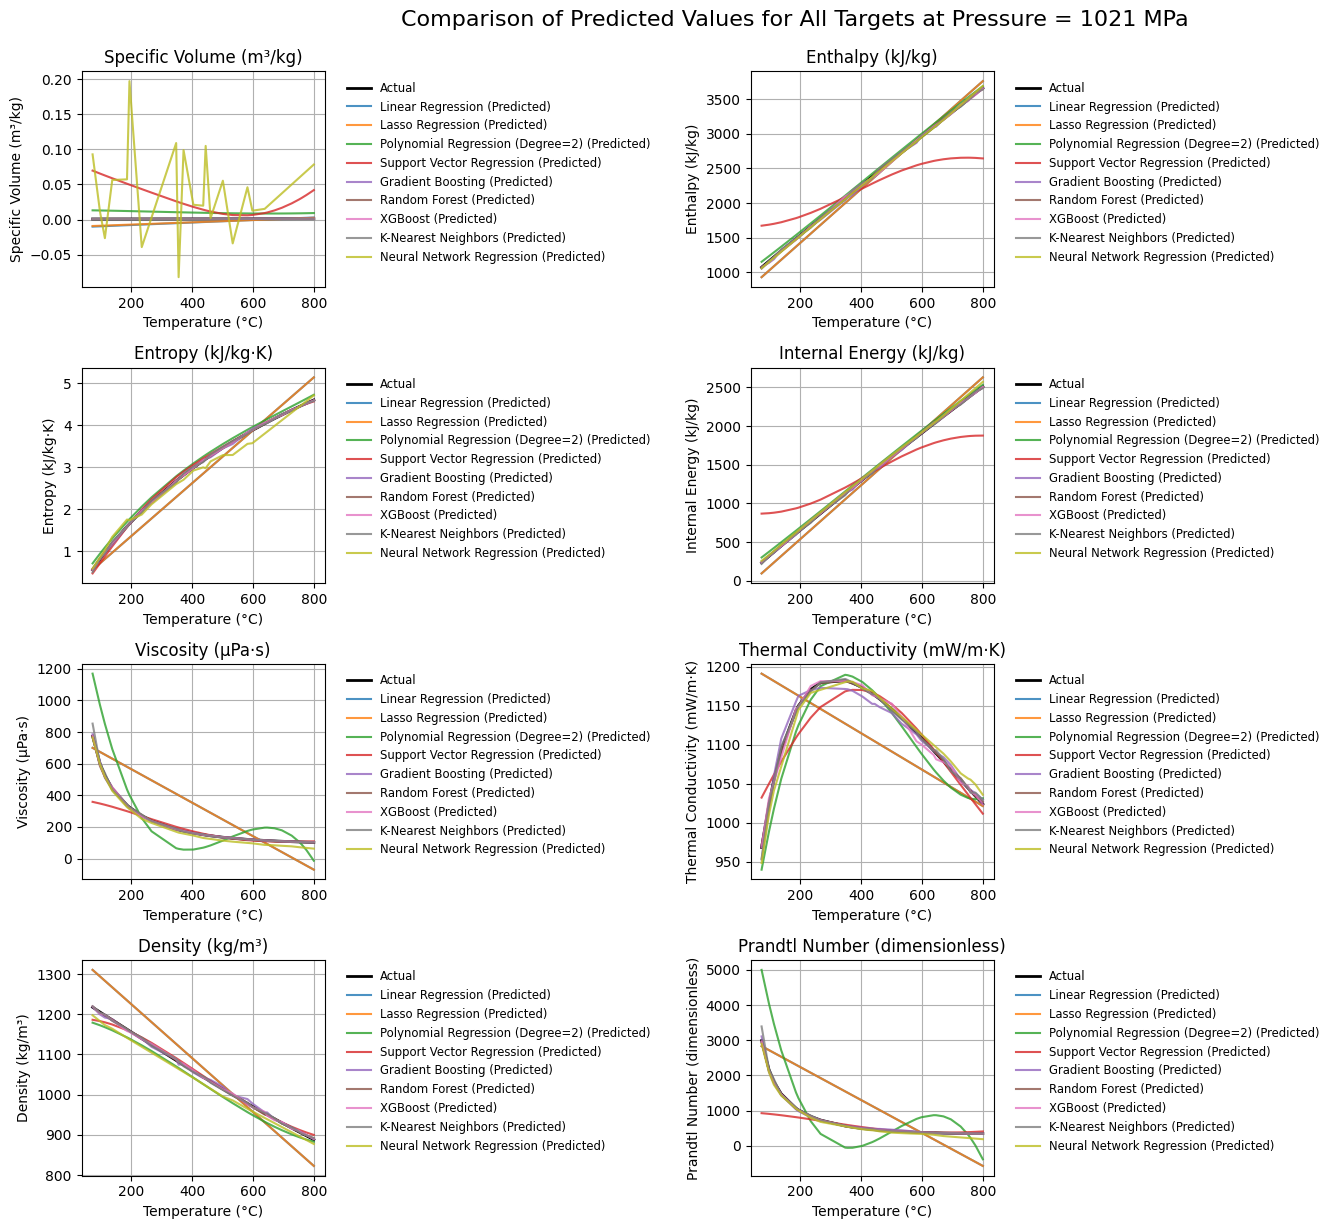

In [11]:
plot_all_targets_comparison_for_regressors(results, Xts, yts, pressure=1021,target_labels=target_labels)


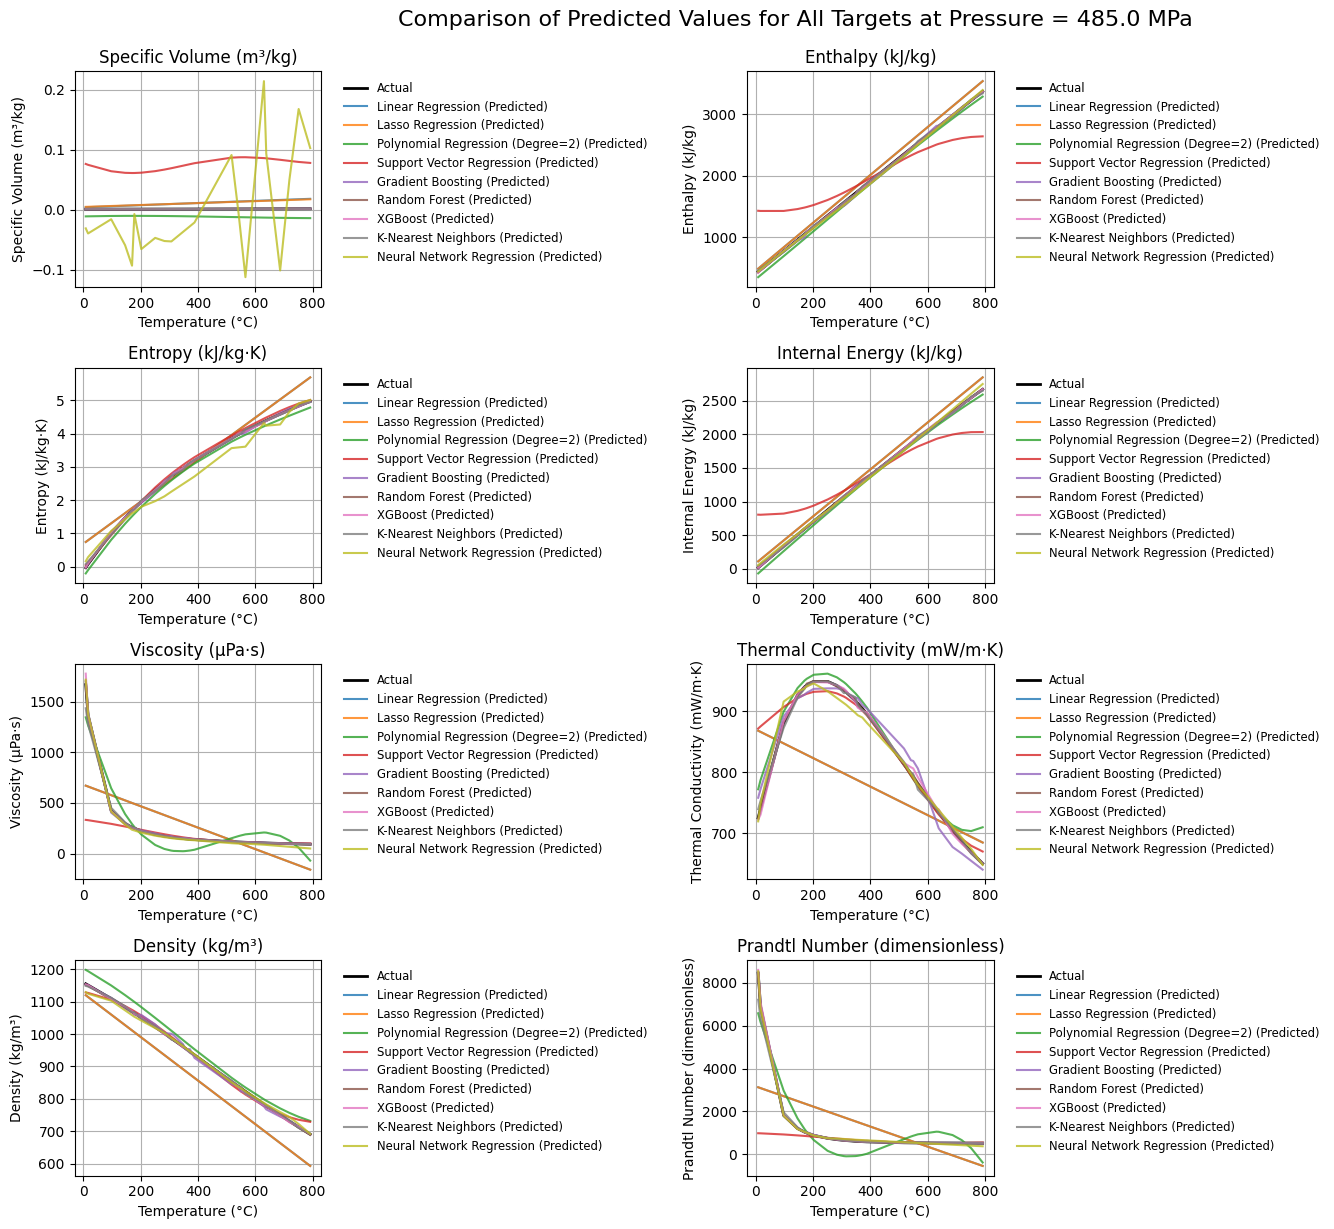

In [12]:
plot_all_targets_comparison_for_regressors(results, Xts, yts, pressure=485.0,target_labels=target_labels)

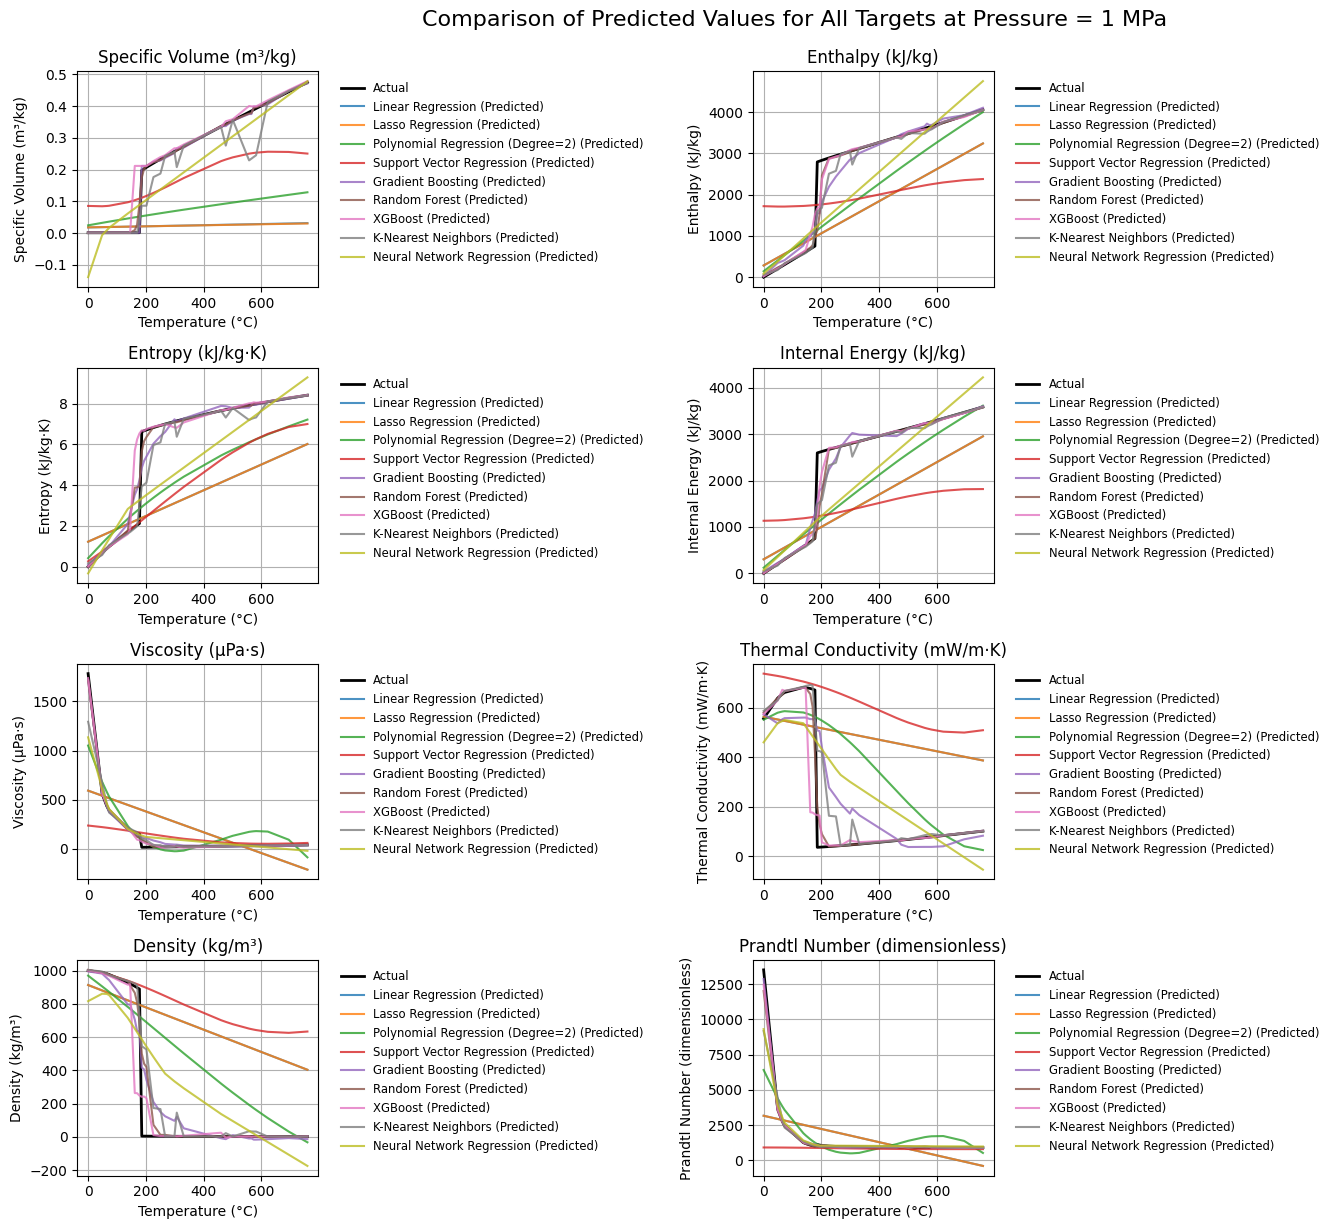

In [13]:
plot_all_targets_comparison_for_regressors(results, Xts, yts, pressure=1,target_labels=target_labels)

In [14]:
# Train a multi-output regression model
model = MultiOutputRegressor(RandomForestRegressor(random_state=3))
model.fit(Xtr, ytr)
# Predict on the test set
ypred = model.predict(Xts)
# Calculate the Mean Squared Error for each target variable
mse = mean_squared_error(yts, ypred, multioutput='raw_values')
# Display the MSE for each target in a readable format
print("Mean Squared Error for each target variable:")
for label, error in zip(target_labels, mse):
    print(f"{label}: {error:.4e}")  # Formats the error in scientific notation with 4 decimal places

Mean Squared Error for each target variable:
Specific Volume (m³/kg): 6.2570e-06
Enthalpy (kJ/kg): 3.1994e+03
Entropy (kJ/kg·K): 8.4142e-03
Internal Energy (kJ/kg): 3.2831e+03
Viscosity (μPa·s): 1.4389e+02
Thermal Conductivity (mW/m·K): 8.7817e+01
Density (kg/m³): 4.5428e+02
Prandtl Number (dimensionless): 3.9536e+03


In [15]:
def plot_viscosity_comparison_at_pressure(Xts, yts, ypred, pressure):
    # Filter the test data for the specified pressure
    indices_at_pressure = np.isclose(Xts[:, 0], pressure, atol=0.01)  # Check pressure in the first column of Xts
    temperatures = Xts[indices_at_pressure, 1]  # Extract temperatures for the filtered rows
    actual_viscosity = yts[indices_at_pressure, 5]  # Actual viscosity for the filtered rows
    predicted_viscosity = ypred[indices_at_pressure, 5]  # Predicted viscosity for the filtered rows
    if len(temperatures) > 0:  # Ensure there are data points to plot
        plt.figure(figsize=(10, 6))
        plt.scatter(temperatures, actual_viscosity, color='blue', label='Actual Viscosity', alpha=0.5, s=10, marker='o')
        plt.scatter(temperatures, predicted_viscosity, color='red', label='Predicted Viscosity', alpha=0.5, s=10, marker='x')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Viscosity (μPa·s)')
        plt.title(f'Actual vs Predicted Viscosity at Pressure = {pressure} MPa')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"No test data found for Pressure = {pressure} MPa")

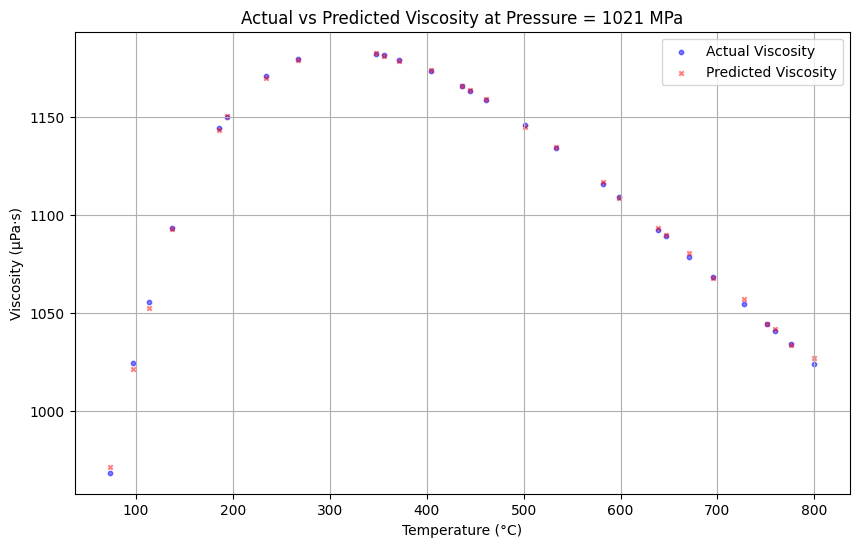

In [16]:
# Example: Compare actual and predicted viscosity for a specific pressure in the test set
plot_viscosity_comparison_at_pressure(Xts, yts, ypred, pressure=1021)

In [17]:
def plot_targets_comparison_at_pressure(Xts, yts, ypred, pressure, target_labels):
    # Filter the test data for the specified pressure
    indices_at_pressure = np.isclose(Xts[:, 0], pressure, atol=0.01)  # Check pressure in the first column of Xts
    temperatures = Xts[indices_at_pressure, 1]  # Extract temperatures for the filtered rows
    if len(temperatures) > 0:  # Ensure there are data points to plot
        num_targets = yts.shape[1]  # Number of target columns
        plt.figure(figsize=(12, 8))
        for i in range(num_targets):
            actual_values = yts[indices_at_pressure, i]  # Actual values for the current target
            predicted_values = ypred[indices_at_pressure, i]  # Predicted values for the current target
            # Plot actual and predicted values for the current target
            plt.subplot((num_targets + 1) // 2, 2, i + 1)  # Create subplots in a grid format
            plt.scatter(temperatures, actual_values, color='blue', label='Actual', alpha=0.7, s=10, marker='o')
            plt.scatter(temperatures, predicted_values, color='red', label='Predicted', alpha=0.7, s=10, marker='x')
            plt.title(f'{target_labels[i]}')
            plt.xlabel('Temperature (°C)')
            plt.ylabel(target_labels[i])
            plt.legend()
            plt.grid(True)
        plt.tight_layout()  # Adjust layout for better visualization
        plt.suptitle(f'Actual vs Predicted Values at Pressure = {pressure} MPa', y=1.02, fontsize=16)
        plt.show()
    else:
        print(f"No test data found for Pressure = {pressure} MPa")

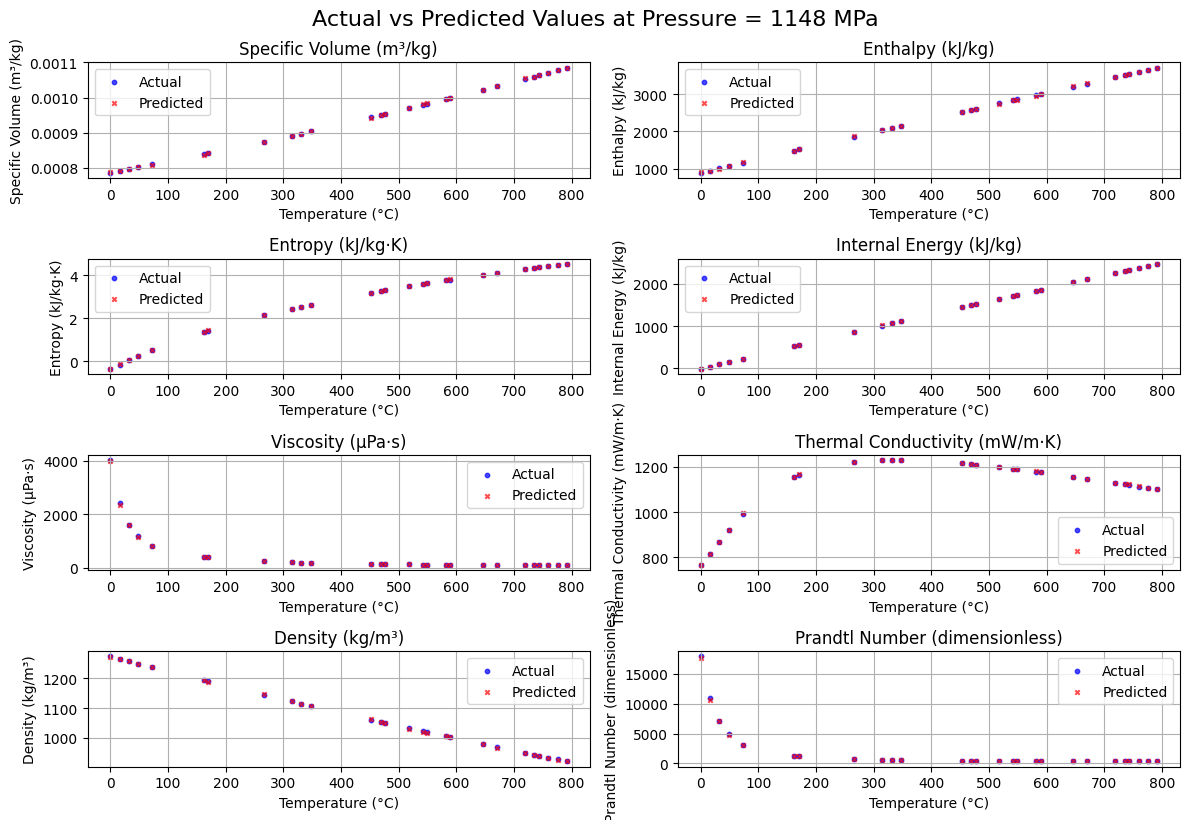

In [18]:
# Call the function to plot all targets for a specific pressure
plot_targets_comparison_at_pressure(Xts, yts, ypred, pressure=1148, target_labels=target_labels)

In [19]:
def plot_predicted_values_at_pressure_and_temperature_range_with_model(model, Xts, pressure, temp_min, temp_max, target_labels):
    # Generate new input data for the specified pressure and temperature range
    temperatures = np.linspace(temp_min, temp_max, 100)  # Generate 100 points in the temperature range
    pressures = np.full_like(temperatures, pressure)  # Fixed pressure value for all points
    X_new = np.column_stack((pressures, temperatures))  # Combine into feature array
    # Predict values using the trained model
    ypred_new = model.predict(X_new)
    if len(temperatures) > 0:  # Ensure there are data points to plot
        num_targets = ypred_new.shape[1]  # Number of target variables
        plt.figure(figsize=(12, 8))
        for i in range(num_targets):
            # Plot predicted values for the current target
            plt.subplot((num_targets + 1) // 2, 2, i + 1)  # Create subplots in a grid format
            plt.plot(temperatures, ypred_new[:, i], color='green', label='Predicted')
            plt.title(f'{target_labels[i]}')
            plt.xlabel('Temperature (°C)')
            plt.ylabel(target_labels[i])
            plt.legend()
            plt.grid(True)
        plt.tight_layout()  # Adjust layout for better visualization
        plt.suptitle(f'Predicted Values at Pressure = {pressure} MPa\nTemperature Range = {temp_min}–{temp_max} °C', y=1.02, fontsize=16)
        plt.show()
    else:
        print(f"No predicted data found for Pressure = {pressure} MPa in the range {temp_min}–{temp_max} °C")

Generating Predictions Plots of Target Varibales At Supercritical Conditions


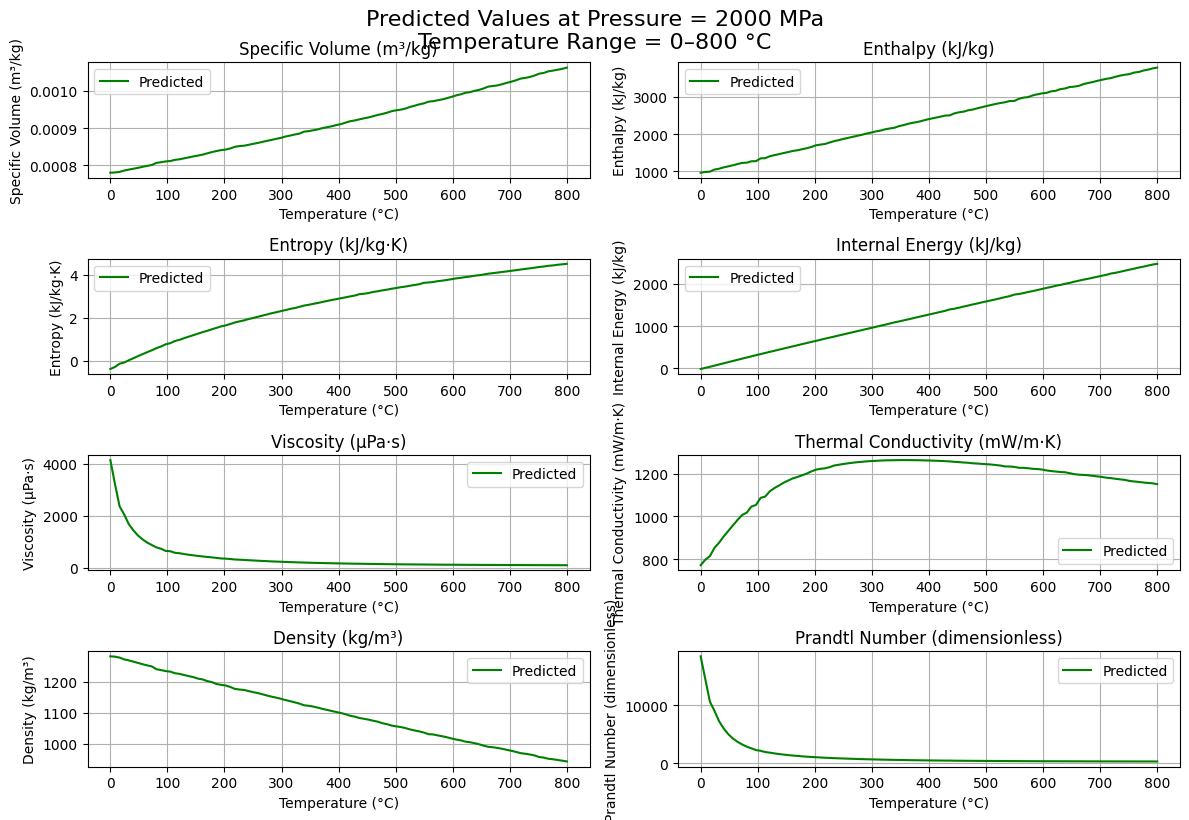

In [20]:
plot_predicted_values_at_pressure_and_temperature_range_with_model(
    model, Xts, pressure=2000, temp_min=0, temp_max=800, target_labels=target_labels
)